<a href="https://colab.research.google.com/github/alessandrossC/Detecting_Fake_News/blob/main/01_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split

nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

from tqdm.auto import tqdm
tqdm.pandas()

np.random.seed(7)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [5]:
df = pd.read_csv('/content/fake_news_full_data.csv', sep=None, engine='python')
print(df.head())

   Unnamed: 0                                              title  \
0           0               Earthquake hits off Papua New Guinea   
1           1  CINDY MCCAIN Reportedly Accepts Trump Administ...   
2           2  Prosecutors say ex-House Speaker Hastert sexua...   
3           3  Romanian protesters halt building of Xmas fair...   
4           4  Congo elected to U.N. rights council; Britain,...   

                                                text                 date  \
0  LONDON (Reuters) - A magnitude 5.9 earthquake ...  September 17, 2017    
1  The Hill released controversial comments sore ...         Jun 12, 2017   
2  (Reuters) - Former U.S. House Speaker Dennis H...       April 9, 2016    
3  BUCHAREST (Reuters) - Romanian protesters clas...    December 2, 2017    
4  UNITED NATIONS (Reuters) - Democratic Republic...    October 16, 2017    

   is_fake  
0        0  
1        1  
2        0  
3        0  
4        0  


In [26]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['is_fake']
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print("Train class distribution:\n", train_df['is_fake'].value_counts(normalize=True))
print("Validation class distribution:\n", val_df['is_fake'].value_counts(normalize=True))

Train size: 35744
Validation size: 8936
Train class distribution:
 is_fake
1    0.525263
0    0.474737
Name: proportion, dtype: float64
Validation class distribution:
 is_fake
1    0.525291
0    0.474709
Name: proportion, dtype: float64


In [7]:
# Check for missing values
print("=== Missing Values in train_df ===")
missing_data = train_df.isnull().sum()
if (missing_data > 0).any():
    print(missing_data[missing_data > 0])
else:
    print("No missing values found.")

# Check for duplicate rows
print("\n=== Duplicate Rows in train_df ===")
duplicates = train_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

=== Missing Values in train_df ===
No missing values found.

=== Duplicate Rows in train_df ===
Number of duplicate rows: 0


In [8]:
#Text Preprocessing
def clean_text(text):
    """Basic text cleaning"""
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = str(text).lower()
    # Remove punctuation (replace with space)
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

def preprocess_pipeline(text, remove_stopwords=True, stem=True):
    """Process text by cleaning and tokenizing"""
    cleaned_text = clean_text(text)
    if not cleaned_text:
        return ""
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')
    tokens = word_tokenize(cleaned_text)
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]
    if stem:
        tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

In [9]:
train_df['text_clean'] = train_df['text'].progress_apply(preprocess_pipeline)
train_df['title_clean'] = train_df['title'].progress_apply(preprocess_pipeline)

print("Text preprocessing completed!")

  0%|          | 0/35744 [00:00<?, ?it/s]

  0%|          | 0/35744 [00:00<?, ?it/s]

Text preprocessing completed!


In [10]:
print("Preprocessing examples:")
for i in np.random.choice(train_df.index, size=3, replace=False):
    print(f"\nExample {i}:")
    print(f"Original Title: {train_df.loc[i, 'title']}")
    print(f"Cleaned Title:  {train_df.loc[i, 'title_clean']}")
    print(f"Original Text:  {train_df.loc[i, 'text']}")
    print(f"Cleaned Text:   {train_df.loc[i, 'text_clean']}")

Preprocessing examples:

Example 31984:
Original Title: Indonesia condemns U.S. decision to recognize Jerusalem as Israeli capital
Cleaned Title:  indonesia condemn u decis recogn jerusalem isra capit
Original Text:  Bogor, INDONESIA (Reuters) - Indonesian President Joko Widodo, leader of the world s largest Muslim-majority nation, onThursday condemned the U.S. decision to recognize Jerusalem as Israel s capital.  Indonesia strongly condemns the United States  unilateral recognition of Jerusalem as the capital of Israel and asks the U.S. to reconsider the decision,  Widodo told a news conference.  This can rock global security and stability,  he said. 
Cleaned Text:   bogor indonesia reuter indonesian presid joko widodo leader world largest muslim major nation onthursday condemn u decis recogn jerusalem israel capit indonesia strong condemn unit state unilater recognit jerusalem capit israel ask u reconsid decis widodo told news confer rock global secur stabil said

Example 26793:
Orig

In [13]:
#Feature Engineering
def calculate_text_features(df):
    """
    Create various text-based features for title and text columns.
    Args:
        df: DataFrame containing text data.
    Returns:
        DataFrame with additional features.
    """
    df = df.copy()
    # Length features
    df['title_len'] = df['title_clean'].str.len()
    df['text_len'] = df['text_clean'].str.len()
    df['len_diff'] = abs(df['title_len'] - df['text_len'])
    df['len_ratio'] = (df[['title_len', 'text_len']].min(axis=1) / (df[['title_len', 'text_len']].max(axis=1) + 1e-5))

    # Word count features
    df['title_words'] = df['title_clean'].str.split().str.len()
    df['text_words'] = df['text_clean'].str.split().str.len()
    df['words_diff'] = abs(df['title_words'] - df['text_words'])
    df['words_ratio'] = (df[['title_words', 'text_words']].min(axis=1) / (df[['title_words', 'text_words']].max(axis=1) + 1e-5))

    # Statistical features
    df['title_question_marks'] = df['title'].apply(lambda x: str(x).count('?'))
    df['text_question_marks'] = df['text'].apply(lambda x: str(x).count('?'))
    df['question_marks_diff'] = abs(df['title_question_marks'] - df['text_question_marks'])

    df['title_dots'] = df['title'].apply(lambda x: str(x).count('.'))
    df['text_dots'] = df['text'].apply(lambda x: str(x).count('.'))
    df['dots_diff'] = abs(df['title_dots'] - df['text_dots'])

    df['title_punctuations'] = df['title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['text_punctuations'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['punctuations_diff'] = abs(df['title_punctuations'] - df['text_punctuations'])

    df['title_numbers'] = df['title'].apply(lambda x: len([c for c in str(x) if c.isdigit()]))
    df['text_numbers'] = df['text'].apply(lambda x: len([c for c in str(x) if c.isdigit()]))
    df['numbers_diff'] = abs(df['title_numbers'] - df['text_numbers'])

    df['title_uppercase'] = df['title'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    df['text_uppercase'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    df['uppercase_diff'] = abs(df['title_uppercase'] - df['text_uppercase'])

    df['title_titlecase'] = df['title'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df['text_titlecase'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df['titlecase_diff'] = abs(df['title_titlecase'] - df['text_titlecase'])

    # Common words features
    def get_word_overlap_features(row):
        title_words = set(row['title_clean'].split())
        text_words = set(row['text_clean'].split())

        common_words = title_words.intersection(text_words)
        unique_words = title_words.union(text_words)
        jaccard = (len(common_words) / len(unique_words)) if len(unique_words) > 0 else 0

        return pd.Series({
            'common_words_count': len(common_words),
            'unique_words_count': len(unique_words),
            'jaccard_similarity': jaccard,
        })

    overlap_features = df.apply(get_word_overlap_features, axis=1)
    df = pd.concat([df, overlap_features], axis=1)

    return df

In [14]:
print("Creating basic features...")

initial_feature_count = len(train_df.columns)

train_processed = calculate_text_features(train_df)

print("\nFeature engineering completed!")
print(f"Total features created: {len(train_processed.columns) - initial_feature_count}")
print(f"Dataset shape before feature engineering: {train_df.shape}")
print(f"Final dataset shape: {train_processed.shape}")

Creating basic features...

Feature engineering completed!
Total features created: 29
Dataset shape before feature engineering: (35744, 7)
Final dataset shape: (35744, 36)


In [15]:
#Exploratory Data Analysis of Processed Features
feature_cols = [col for col in train_processed.columns if col not in train_df.columns]
print("Feature columns:\n", feature_cols)

Feature columns:
 ['title_len', 'text_len', 'len_diff', 'len_ratio', 'title_words', 'text_words', 'words_diff', 'words_ratio', 'title_question_marks', 'text_question_marks', 'question_marks_diff', 'title_dots', 'text_dots', 'dots_diff', 'title_punctuations', 'text_punctuations', 'punctuations_diff', 'title_numbers', 'text_numbers', 'numbers_diff', 'title_uppercase', 'text_uppercase', 'uppercase_diff', 'title_titlecase', 'text_titlecase', 'titlecase_diff', 'common_words_count', 'unique_words_count', 'jaccard_similarity']


In [16]:
print("Feature statistics:")
display(train_processed[feature_cols].describe().round(2).T)

Feature statistics:


,count,mean,std,min,25%,50%,75%,max
title_len,35744.0,58.22,17.45,7.0,47.00,54.00,65.00,223.00
text_len,35744.0,1521.00,1358.08,0.0,768.00,1332.00,1900.00,33162.00
len_diff,35744.0,1465.23,1355.17,0.0,709.00,1276.00,1841.25,33069.00
len_ratio,35744.0,0.07,0.11,0.0,0.03,0.04,0.08,1.00
title_words,35744.0,9.58,2.88,1.0,8.00,9.00,11.00,35.00
text_words,35744.0,238.84,212.06,0.0,121.00,211.00,299.00,5069.00
words_diff,35744.0,229.66,211.57,0.0,111.00,201.00,289.00,5055.00
words_ratio,35744.0,0.08,0.11,0.0,0.03,0.04,0.08,1.00
title_question_marks,35744.0,0.04,0.21,0.0,0.00,0.00,0.00,3.00
text_question_marks,35744.0,0.68,1.81,0.0,0.00,0.00,1.00,94.00


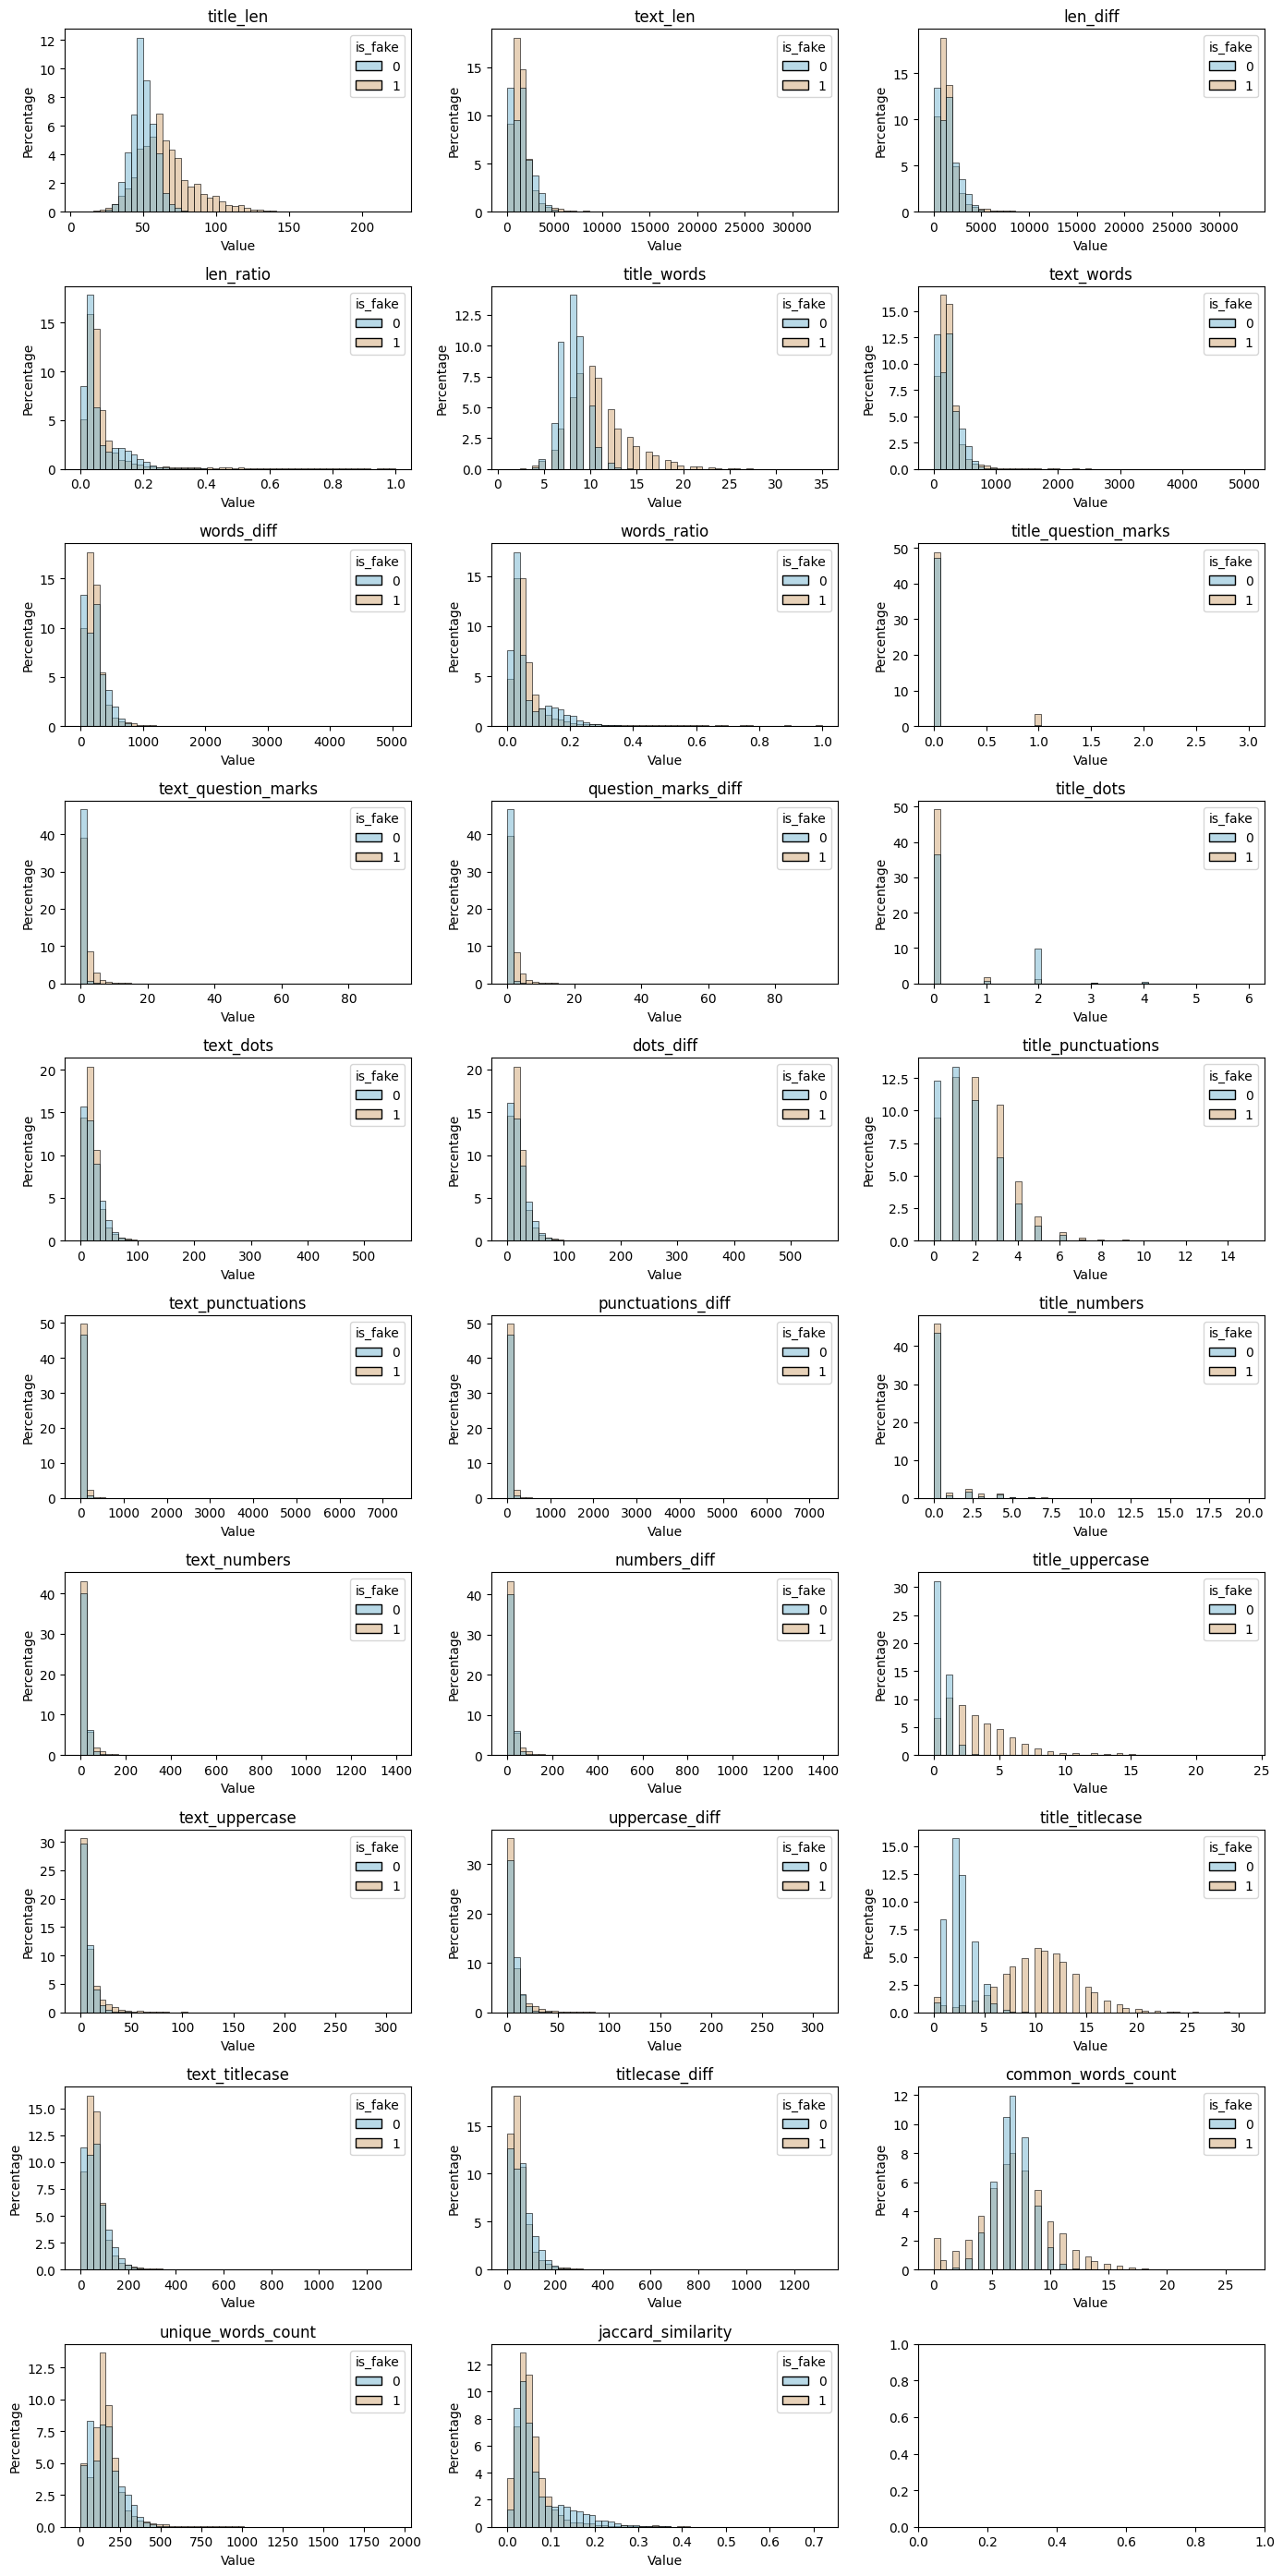

In [17]:
fig, axes = plt.subplots(10, 3, figsize=(14, 28))
axes = axes.ravel()
palette = {1: '#D1A573', 0: '#73B5D1'}

for i, col in enumerate(feature_cols):
    sns.histplot(
        train_processed,
        x=col,
        hue='is_fake',
        bins=50,
        ax=axes[i],
        palette=palette,
        stat='percent'
    )
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

In [21]:
print(train_processed['is_fake'].unique(), train_processed['is_fake'].dtype)

[1 0] int64


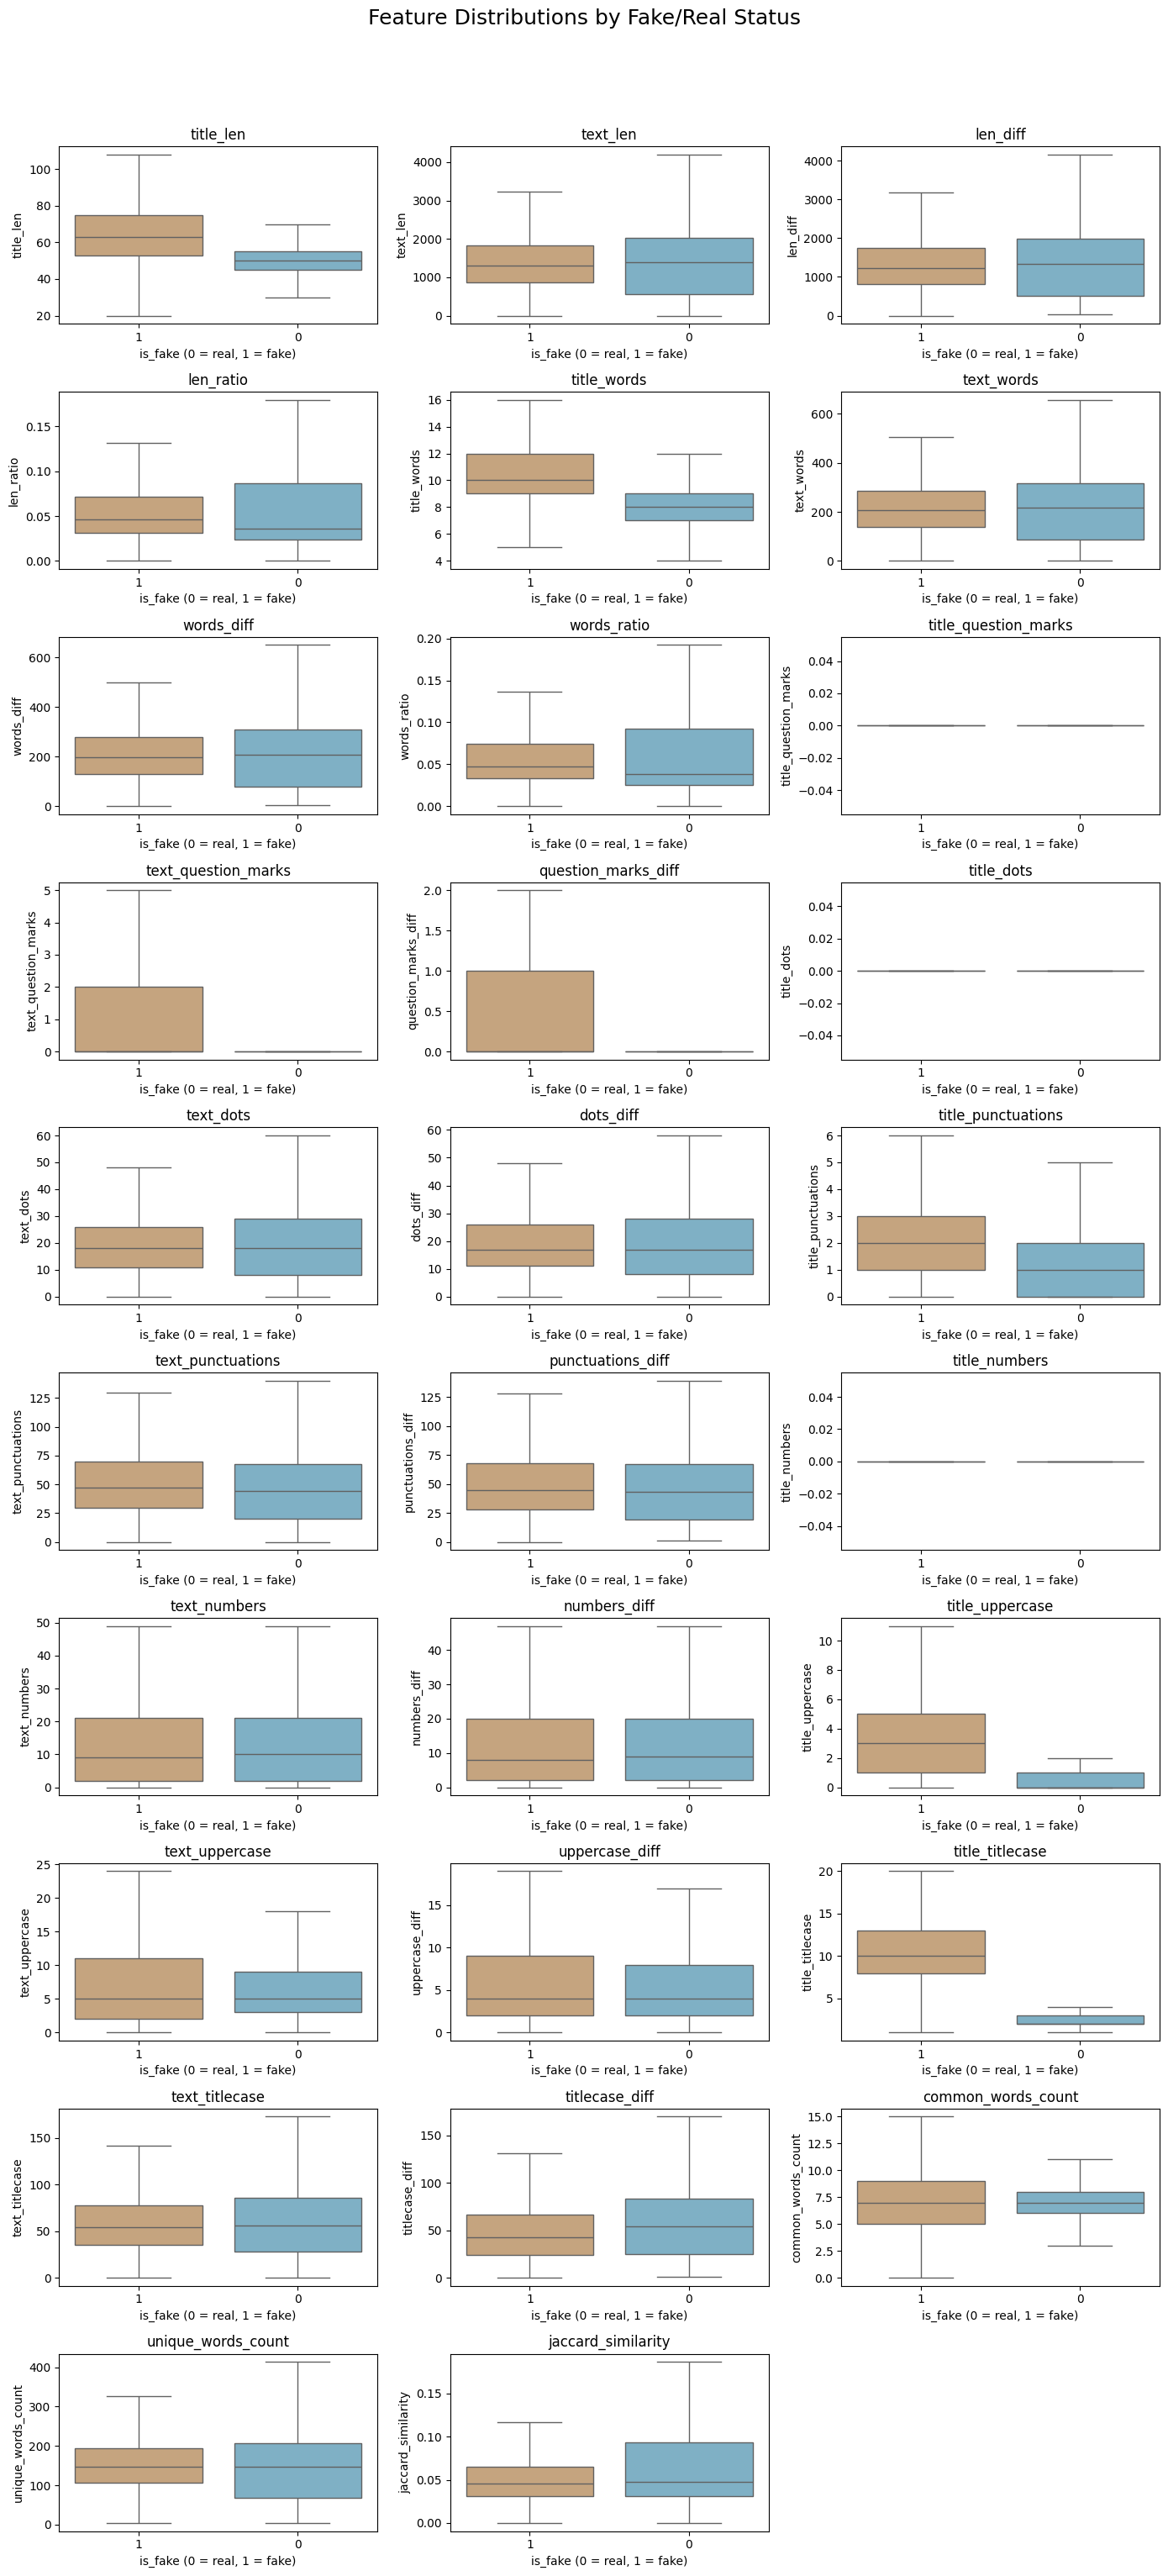

In [24]:
palette = {'0': '#73B5D1', '1': '#D1A573'}

train_processed['is_fake_str'] = train_processed['is_fake'].astype(str)

n_feats = len(feature_cols)
ncols = 3
nrows = (n_feats + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(14, nrows*3))
axes = axes.ravel()

plt.suptitle('Feature Distributions by Fake/Real Status\n', fontsize=18, y=1.02)

for i, col in enumerate(feature_cols):
    sns.boxplot(
        data=train_processed,
        x='is_fake_str',
        y=col,
        ax=axes[i],
        palette=palette,
        showfliers=False
    )
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('is_fake (0 = real, 1 = fake)')
    axes[i].set_ylabel(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Fake news typically have longer, more attention-grabbing headlines, but shorter article texts. They use more punctuation and question marks, likely to provoke emotions or curiosity. In contrast, real news headlines are shorter and texts are longer and more consistent, with fewer emotional cues. These features can help distinguish fake from real news in classification models

=== Feature Correlation with Target ===
Top 5 positively correlated features:
title_titlecase        0.775395
title_uppercase        0.546729
title_words            0.461213
title_len              0.459183
text_question_marks    0.302126
Name: is_fake, dtype: float64

Top 5 negatively correlated features:
text_titlecase        0.002981
text_dots             0.000298
titlecase_diff       -0.058277
jaccard_similarity   -0.148025
title_dots           -0.264956
Name: is_fake, dtype: float64


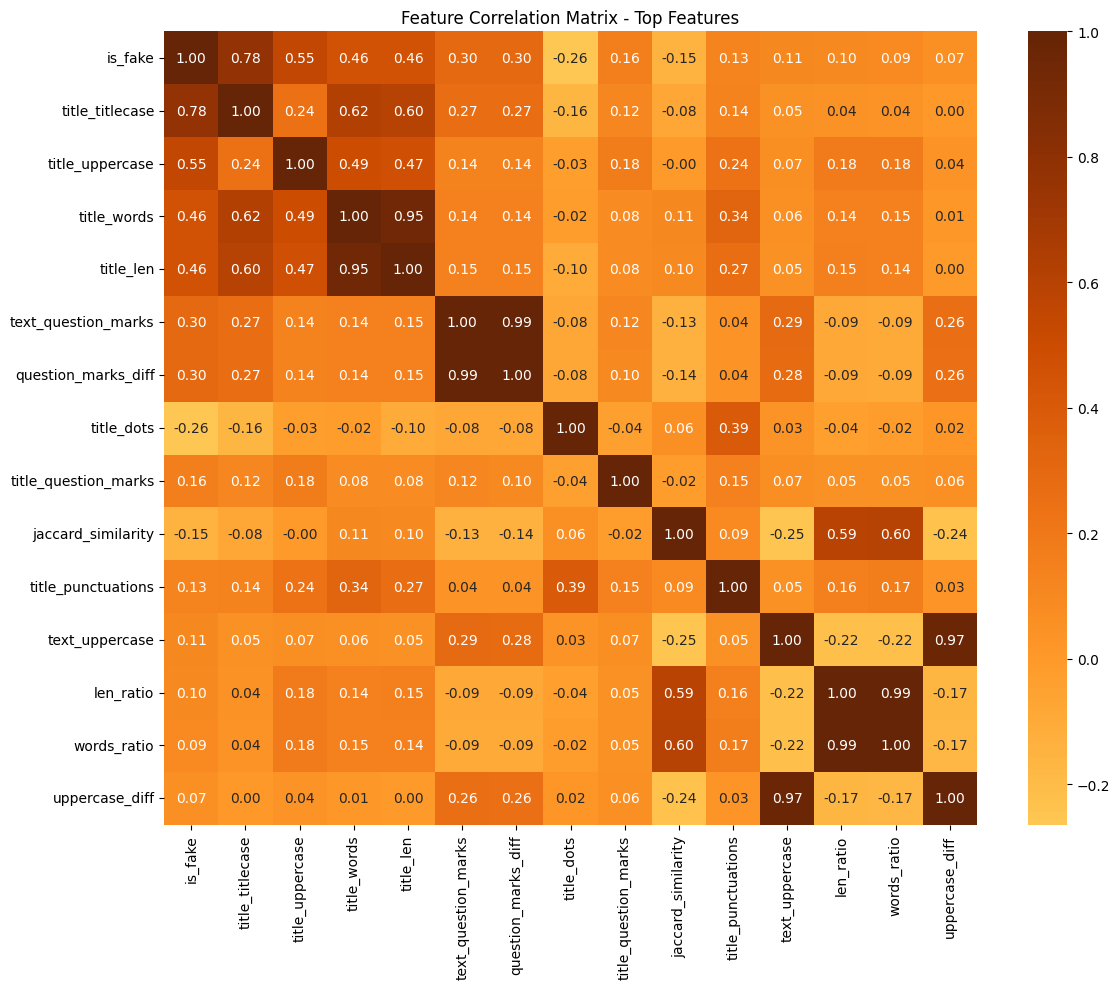

In [25]:
#Correlation Analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("=== Feature Correlation with Target ===")

numeric_cols = train_processed[feature_cols + ['is_fake']].select_dtypes(include=[np.number]).columns

correlations = (
    train_processed[numeric_cols]
    .corr()['is_fake']
    .sort_values(ascending=False)
)

print("Top 5 positively correlated features:")
print(correlations[1:6])

print("\nTop 5 negatively correlated features:")
print(correlations.tail(5))

top_features = correlations.abs().sort_values(ascending=False).head(15).index

plt.figure(figsize=(12, 10))
sns.heatmap(train_processed[top_features].corr(),
            annot=True, cmap='YlOrBr', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix - Top Features')
plt.tight_layout()
plt.show()

Features related to capitalization and title length (number of titlecase or uppercase words in the headline, and the headline length itself) are most strongly positively correlated with fake news. This suggests that fake news articles tend to use longer and more "shouting" headlines, likely to attract attention. Negative correlations (with number of dots in the title and text-title similarity) indicate that real news headlines are more restrained and more similar to the article text. Punctuation features (like question marks) are also indicative. These patterns are highly useful for feature selection and can improve classification accuracy.

In [28]:
print(f"Validation data shape: {val_df.shape}")

print("Processing validation data...")

val_processed = val_df.copy()

val_processed = val_processed.dropna(subset=['title', 'text'])

# Text preprocessing
val_processed['title_clean'] = val_processed['title'].progress_apply(preprocess_pipeline)
val_processed['text_clean'] = val_processed['text'].progress_apply(preprocess_pipeline)

# Feature engineering
print("Creating features for validation data...")
val_processed = calculate_text_features(val_processed)

print(f"Validation data processed successfully! Shape: {val_processed.shape}")


Validation data shape: (8936, 5)
Processing validation data...


  0%|          | 0/8936 [00:00<?, ?it/s]

  0%|          | 0/8936 [00:00<?, ?it/s]

Creating features for validation data...
Validation data processed successfully! Shape: (8936, 36)


In [30]:
train, val = train_test_split(
    train_processed,
    test_size=0.2,
    random_state=7,
    stratify=train_processed['is_fake']
)

print(f"\nData splits:")
print(f"Train: {train.shape[0]} samples ({train['is_fake'].mean():.2%} fake)")
print(f"Validation: {val.shape[0]} samples ({val['is_fake'].mean():.2%} fake)")


Data splits:
Train: 28595 samples (52.53% fake)
Validation: 7149 samples (52.52% fake)


We have successfully split the news dataset into training and validation subsets in an 80/20 ratio using stratified sampling by the is_fake target.
As a result:

Train: 28,595 samples (52.53% fake news)

Validation: 7,149 samples (52.52% fake news)

Both splits have an almost identical class balance.
This ensures that there is no bias during model training and evaluation, and allows for a fair assessment of model performance on unseen data.

In [32]:
print("Saving processed data...")

os.makedirs('processed', exist_ok=True)

train.to_csv('processed/train.csv.zip', index=False, compression='zip')
val.to_csv('processed/val.csv.zip', index=False, compression='zip')

print("Processed data saved to: 'processed/'")

Saving processed data...
Processed data saved to: 'processed/'


In [33]:
text_features = train_processed.select_dtypes(include=[object]).columns.tolist()

feature_info = {
    'numerical_features': feature_cols,
    'text_features': text_features
}

os.makedirs('processed', exist_ok=True)

joblib.dump(feature_info, 'processed/feature_info.joblib')

print("Feature info saved to: 'processed/feature_info.joblib'")

Feature info saved to: 'processed/feature_info.joblib'
